# Regresión lineal con transformación de la variable respuesta

En este notebook mostramos cual sería el resultado de la regresión lineal si realizamos una transformación a la variable respuesta para que su distribución se asemeje más a una distribución normal.

In [4]:
#--variables globales
INPUT_PATH = "/content/drive/MyDrive/data_sets/parquet/sf-airbnb-clean"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install pyspark

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark

In [8]:
#--Librerias
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import RFormula
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np

Leemos el dataset y volvemos a realizar la misma partición que antes en training y test sets.

In [9]:
airbnbDF = spark.read.parquet(INPUT_PATH)
(trainDF, testDF) = airbnbDF.randomSplit([.8, .2], seed=42)

Una variable respuesta con distribución menos sesgada se puede modelar mejor

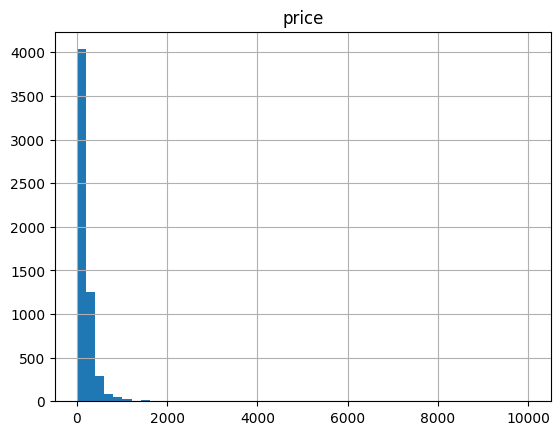

In [10]:
y = (trainDF
      .select('price')
      .toPandas())

y.hist(bins=50);

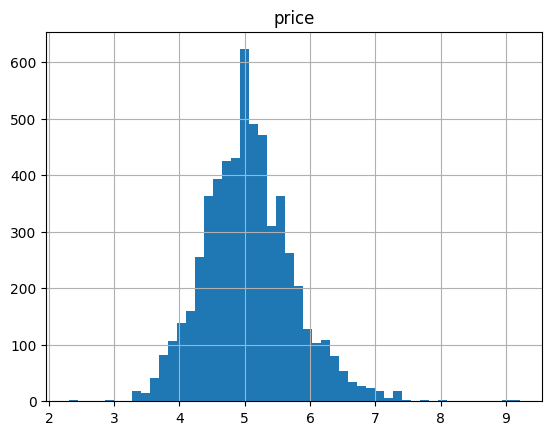

In [11]:
np.log(y).hist(bins=50);

In [12]:
#--aplicamos logaritmo a la variable respuesta, tanto en el training set como en el test set
logTrainDF = trainDF.withColumn("log_price", F.log(F.col("price")))
logTestDF = testDF.withColumn("log_price", F.log(F.col("price")))

#--definimos nuestro modelo, log_price como variable respuesta y todas las demás
#-columnas como predictores, excepto por la columna "price"
rFormula = RFormula(formula="log_price ~ . - price",
                    featuresCol="features",
                    labelCol="log_price",
                    handleInvalid="skip")

#--inicializamos nuestro estimador de regresión lineal
lr = LinearRegression(labelCol="log_price",
                      predictionCol="log_pred")

#--juntados todo en un pipeline
pipeline = Pipeline(stages = [rFormula, lr])

#--entrenamos el modelo
pipelineModel = pipeline.fit(logTrainDF)

#--hacemos la predicción del testset
predDF = pipelineModel.transform(logTestDF)

Para hacer comparable el RMSE de los modelos, necesitamos "exponenciar" los resultados para eliminar el efecto del logaritmo.

In [13]:
#--aplicamos "exponente" a la predicciones logaritmicas
expDF = predDF.withColumn("prediction", F.exp(F.col("log_pred")))

#--creamos un estimador para evular el RMSE
regressionEvaluator = RegressionEvaluator(labelCol="price",
                                          predictionCol="prediction")

#--medimos tanto el RMSE como la R2
rmse = (regressionEvaluator
        .setMetricName("rmse")
        .evaluate(expDF))

r2 = (regressionEvaluator
      .setMetricName("r2")
      .evaluate(expDF))

print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


RMSE: 208.44
R2: 0.25


In [ ]:
spark.stop()